# Exploratory data analysis

## 1) The data

<img src="http://tacodataset.org/img/logonav.png" alt="taco-logo" width="30%">

*Trash Annotations in Context, by Pedro Proença and Pedro Simões*

We will work with data from the [TACO project](http://tacodataset.org/) (Trash Annotations in Context). The images in this project are crowd-sourced, with users manually uploading their images and providing the labels and object masks themselves through an online portal. Submitted images are periodically reviewed, and then added to the official dataset in GitHub. According to its creators, images in the dataset are in contexts ranging *'from tropical beaches to London streets'*. We will describe the dataset in more detail below, but background information on the project can be found on the [TACO website](http://tacodataset.org/) or in the TACO project [GitHub repository](https://github.com/pedropro/TACO). The project creators have also authored an [academic paper](https://arxiv.org/pdf/2003.06975.pdf) with more information on the potential uses of the data.

### Read in data

In [1]:
# Suppressing warnings to maintain clean output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import our helper functions to resize images
import sys
import os
path = os.path.abspath('../')
sys.path.append(path)
from helpers import *

In [3]:
# Import other packages
%matplotlib inline
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

In [4]:
# Retrieve directory where we will get the raw data from
parent_directory = os.path.abspath('../')
dataset_path = os.path.join(parent_directory,'data/TACO/data')

# Retrieve directory where we will get save processed data and features
features_path = os.path.join(parent_directory,'data/features')
os.makedirs(features_path, exist_ok=True)

We load in an extract of the TACO data which is composed of:
* 1,500 raw images, stored in 15 sub-folders labelled "batch 1" to "batch 15".
* A json file called "annotations.json", organised in the convenient [COCO-Json](https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-dataset-format/) format, widely used for object detection datasets.

In [5]:
# Read annotations file
with open("{}/annotations.json".format(dataset_path), 'r') as f:
    annotdata = json.loads(f.read())

### Show sample of images

Next, we will visualize a random sample of the images and annotations. To visualize this, we have adapted a function provided by [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335c-visualize-COCO%20labels.pyhttps://github.com/bnsreenu/python_for_microscopists/blob/master/335%20-%20Converting%20COCO%20JSON%20annotations%20to%20labeled%20mask%20images/335c-visualize-COCO%20labels.py) to display images annotated in the COCO-Json format.

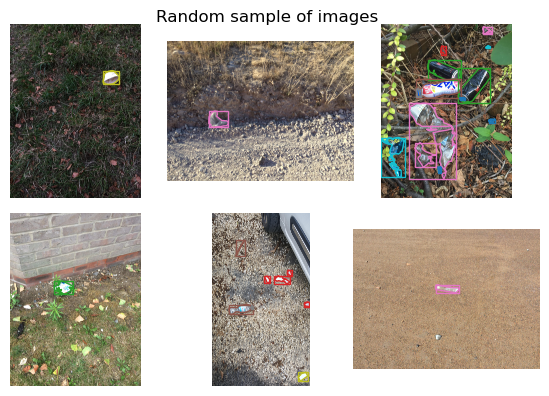

In [6]:
import matplotlib.patches as patches

# Randomly select 6 image IDs from the dataset
random_images = pd.Series([line["id"] for line in annotdata["images"]]).sample(6, random_state=1)

# Display images along with COCO annotations
display_images_with_coco_annotations(
    image_id_subset=random_images,  # Subset of image IDs
    figtitle="Random sample of images",  # Title for the figure
    dataset_path=dataset_path,  # Path to the dataset
    annotations=annotdata,  # COCO annotations
    display_type='both'  # Display type for annotations
)

From our snapshot of the data above, we can see that the images will need some processing before we can apply our machine learning models:

* Often, the object is very small in relation to the image background. This is particularly the case for small objects, like cigarette butts.
* Some objects appear 'distorted' - for example, they are bent or broken. This appears to be more common among objects photographed outdoors and those made of soft materials (like plastic film or cardboard). These distortions might make the images more difficult to classify.
* Object masks (the segmentations, such as the contour of a plastic bottle) are not provided as stand-alone images, so we will need to create them for each annotation.

## 2) Exploratory data analysis

### Missing data and duplicates

#### Image dataset

First, we conduct some exploratory data analysis at the image level. We start by saving the images data into a pandas DataFrame.First, we conduct some exploratory data analysis at the image level. We start by saving the images data into a pandas DataFrame. The images file contains one row per image in the dataset, for a total of 1,500 images. It contains:

* An image id
* Image width
* Image height
* File name (and its batch)
* Type of license

All information on the date captured is missing, and there are no duplicates in the images dataset.

In [7]:
# Preview image data
pd.DataFrame(annotdata["images"]).head()

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...


<Axes: >

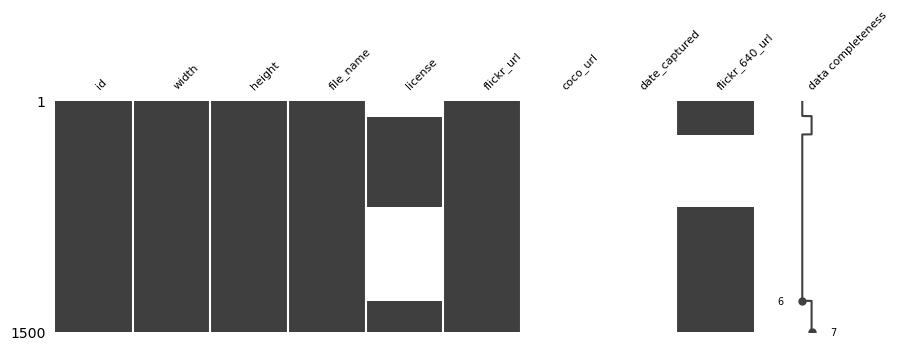

In [8]:
# Check missing data
import missingno as msno
msno.matrix(pd.DataFrame(annotdata["images"]), fontsize=8,labels=True, figsize=(10,3))

#### Annotations dataset

The annotations file is where we will find most of the relevant information for our analysis. This is where each annotation (e.g. the contour of a plastic bottle and the 'plastic bottle' tag) is stored. There are 4,784 annotations in this version of the dataset.

This dataset includes:

* The annotation id (id)
* Its corresponding image id (image_id)
* The category id (category_id), i.e. whether the annotation is a bottle, a pizza box or other.
* The segmentation itself ('segmentation'), with values indicating which pixels are within the segment (also called the 'mask').
* The annotation area ('area').
* The bounding box for the annotation ('bbox'), i.e. the rectangular area containing the edges of the annotation. This is a list of four numbers representing the bounding box of the annotated object in the format [x, y, width, height], where (x, y) is the top-left corner of the bounding box ([more information here on bounding boxes in COCO](https://medium.com/@manuktiwary/coco-format-what-and-how-5c7d22cf5301)).

In [9]:
# Preview data
pd.DataFrame(annotdata["annotations"]).head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1071259.5,"[1.0, 457.0, 1429.0, 1519.0]",0
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",99583.5,"[531.0, 292.0, 1006.0, 672.0]",0
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",915.0,"[632.0, 989.0, 44.0, 51.0]",0


In [10]:
# Save to DataFrame
annot_df = pd.DataFrame(annotdata["annotations"]).drop(["area"], axis=1)

We drop the duplicated annotation (which is tagged with two different categories).

In [11]:
# Drop duplicates
annot_df.drop_duplicates(subset=['id'], keep='first', inplace=True)

Then, we merge in the annotation category labels so that we can conveniently see to which category and supercategory each annotation belongs.

In [12]:
# Merge annotations to image data
categories_dict = pd.DataFrame(annotdata["categories"]).loc[:,["id","name","supercategory"]]
categories_dict.rename({'id': 'category_id', 'name': 'category'}, axis=1, inplace=True)
annot_df = annot_df.merge(categories_dict, on='category_id', how='left').copy()
annot_df.head()

,id,image_id,category_id,segmentation,bbox,iscrowd,category,supercategory
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...","[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Bottle
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...","[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Carton
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...","[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Carton
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...","[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Bottle
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...","[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Bottle cap


We would like to visualize the most common supercategories. The most common supercategory is **plastic bag and wrapper**, which contains many different types of objects such as plastic film, carrier bags and crisp packets. The second most common supercategory are **cigarettes**, followed by **unlabelled litter**. Some supercategories, like shoes or batteries, are very rare.

In [13]:
# Counts by image category
counts_by_cat = pd.DataFrame(annot_df.groupby(["supercategory","category"]).size(),columns=["count"]).reset_index()
counts_by_cat["supercount"] = counts_by_cat.groupby("supercategory")["count"].transform('sum')
counts_by_cat = counts_by_cat.sort_values(by=['supercount','count'], ascending=False)

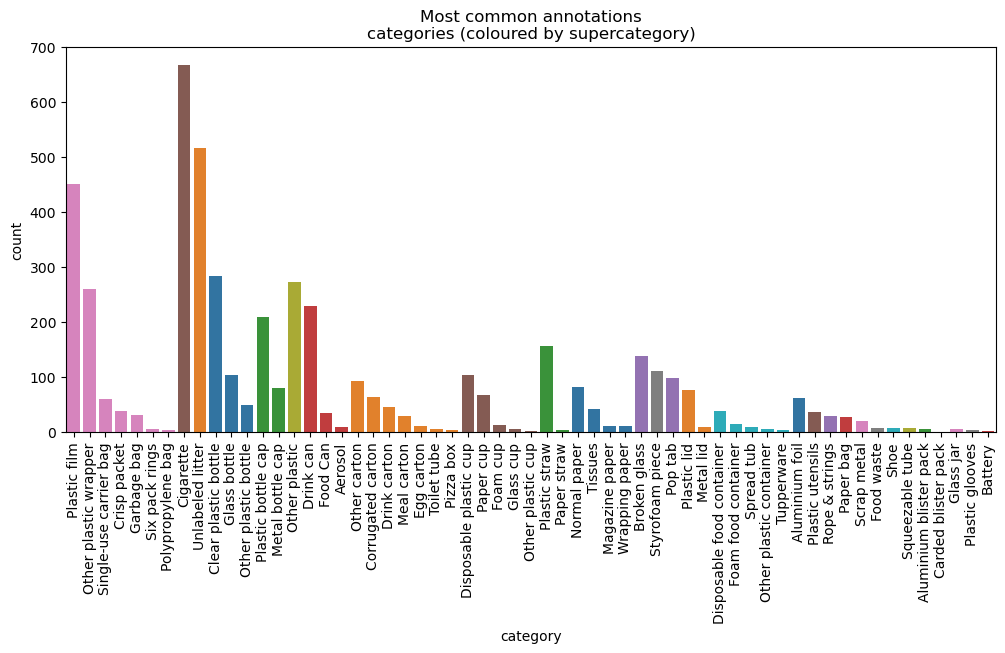

In [14]:
# Bar chart
plt.figure(figsize=(12,5))
sns.countplot(annot_df, x="category", orient="v", hue="supercategory", order=counts_by_cat.category, palette="tab10", legend=False)
plt.xticks(rotation = 90)
plt.title("Most common annotations\ncategories (coloured by supercategory)")
plt.show()

### Create class labels for classification problems

Our classification task will try to distinguish between five types of objects:
* Bottles
* Cartons
* Cups
* Cans
* Plastic film

We create the string variable 'c1_label' containing the object labels according to the above taxonomy, and its numerical version 'c1_numlabel'.

In [15]:
# Create the c1 "label" variable
annot_df["c1_label"] = np.nan
annot_df.loc[annot_df["supercategory"]=="Bottle","c1_label"] = "Bottle"
annot_df.loc[annot_df["supercategory"]=="Carton","c1_label"] = "Carton"
annot_df.loc[annot_df["supercategory"]=="Cup","c1_label"] = "Cup"
annot_df.loc[annot_df["category"].isin(["Drink can","Food can"]),"c1_label"] = "Can"
annot_df.loc[annot_df["category"].isin(["Plastic film"]),"c1_label"] = "Plastic film"

# Create the numerical "label" variable
annot_df["c1_numlabel"] = annot_df['c1_label'].replace(list(annot_df['c1_label'].value_counts().index),list(range(1,6)), inplace=False)

## 3) Save data

Having merged the information on images properties (e.g. size and bounding box coverage), background annotations and class labels to our annotations dataframe, we can save this DataFrame to a '.csv' file locally.

In [16]:
# Preview data
annot_df.head()

,id,image_id,category_id,segmentation,bbox,iscrowd,category,supercategory,c1_label,c1_numlabel
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...","[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle,Bottle,Bottle,2.0
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...","[1.0, 457.0, 1429.0, 1519.0]",0,Meal carton,Carton,Carton,3.0
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...","[531.0, 292.0, 1006.0, 672.0]",0,Other carton,Carton,Carton,3.0
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...","[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle,Bottle,Bottle,2.0
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...","[632.0, 989.0, 44.0, 51.0]",0,Plastic bottle cap,Bottle cap,NaN,NaN


In [17]:
# Save data
annot_df.to_csv("{}/{}".format(features_path,"clean-annotations-data.csv"))